In [58]:
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm
import skimage.feature as feature
import numpy as np
import matplotlib.patches as patches
import os

In [60]:
y_categories={
    "red": "adult males",
    "magenta": "subadult males",
    "brown": "adult females",
    "blue": "juveniles",
    "green": "pups"
}
files=glob.glob("../Downsampled/Train/*.jpg")
files=sorted(files)
filesdotted=glob.glob("../Downsampled/TrainDotted/*.jpg")
filesdotted=sorted(filesdotted)
data=pd.read_csv("../Downsampled/Train/train.csv",index_col="train_id")

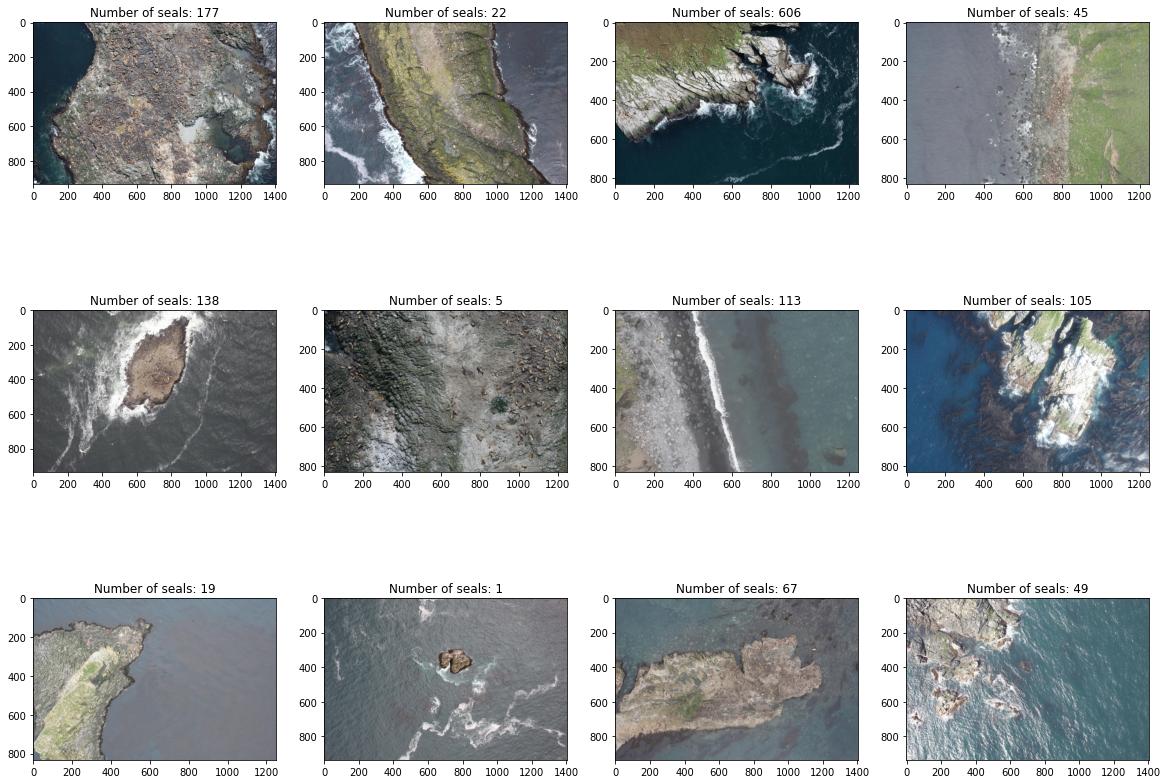

In [61]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
axs = axs.flatten()
i=0
for file, ax in zip(files, axs):  
    img=plt.imread(file)
    ax.title.set_text("Number of seals: " + str(data.sum(axis=1)[41+i]))
    ax.imshow(img)
    i+=1
plt.show()

In [62]:
classes = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups", "error"]
# dataframe to store results in
count_df = pd.DataFrame(index=files, columns=classes).fillna(0)
blob_list=[]

for i in tqdm(range(len(files))):
    
    # read the Train and Train Dotted images
    image_1 = cv2.imread(files[i])
    image_2 = cv2.imread(filesdotted[i])
    
    # absolute difference between Train and Train Dotted
    image_3 = cv2.absdiff(image_1,image_2)
    
    # mask out blackened regions from Train Dotted
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 20] = 0
    mask_1[mask_1 > 0] = 255
    
    mask_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    mask_2[mask_2 < 20] = 0
    mask_2[mask_2 > 0] = 255
    
    image_4 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
    image_5 = cv2.bitwise_or(image_4, image_4, mask=mask_2) 
    
    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_6 = cv2.cvtColor(image_5, cv2.COLOR_BGR2GRAY)
    
    # detect blobs
    blobs = feature.blob_log(image_6, min_sigma=3, max_sigma=4, num_sigma=1, threshold=0.02)
    
    # prepare the image to plot the results on
    image_7 = cv2.cvtColor(image_6, cv2.COLOR_GRAY2BGR)
    blob_type=[]
    for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        # get the color of the pixel from Train Dotted in the center of the blob
        b,g,r = image_2[int(y)][int(x)][:]
        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if r > 200 and b < 50 and g < 50: # RED
            count_df["adult_males"][files[i]] += 1
            blob_type.append("adult_male")
        elif r > 200 and b > 200 and g < 50: # MAGENTA
            count_df["subadult_males"][files[i]] += 1
            blob_type.append("subadult_male")         
        elif r < 100 and b < 100 and 150 < g < 200: # GREEN
            count_df["pups"][files[i]] += 1
            blob_type.append("pup")
        elif r < 100 and  100 < b and g < 100: # BLUE
            count_df["juveniles"][files[i]] += 1 
            blob_type.append("juvenile")
        elif r < 150 and b < 50 and g < 100:  # BROWN
            count_df["adult_females"][files[i]] += 1
            blob_type.append("adult_female")         
        else:
            count_df["error"][files[i]] += 1
            blob_type.append("error")
            
    blob_list.append([blobs,blob_type,files[i]])
    
img_bb_list=[]
for blobs in blob_list:
    bb_list=[]
    i=0
    for blob in blobs[0]:
        y,x,s=blob
        if blobs[1][i]=="adult_male":
            size=15
        elif blobs[1][i]=="subadult_male":
            size=13
        elif blobs[1][i]=="pup":
            size=5
        elif blobs[1][i]=="juvenile":
            size=10
        elif blobs[1][i]=="adult_female":
            size=10
        elif blobs[1][i]=="error":
            size=10
        y_min=np.int(np.floor(y/4-(size)*s/4))
        y_max=np.int(np.floor(y/4+(size)*s/4))
        x_min=np.int(np.floor(x/4-(size)*s/4))
        x_max=np.int(np.floor(x/4+(size)*s/4))
        bb_list.append([y_min,y_max,x_min,x_max])
        i=i+1
    img_bb_list.append(bb_list)

 51%|█████     | 480/948 [02:11<02:08,  3.64it/s]


error: OpenCV(4.5.4-dev) /tmp/pip-req-build-5mtujfce/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


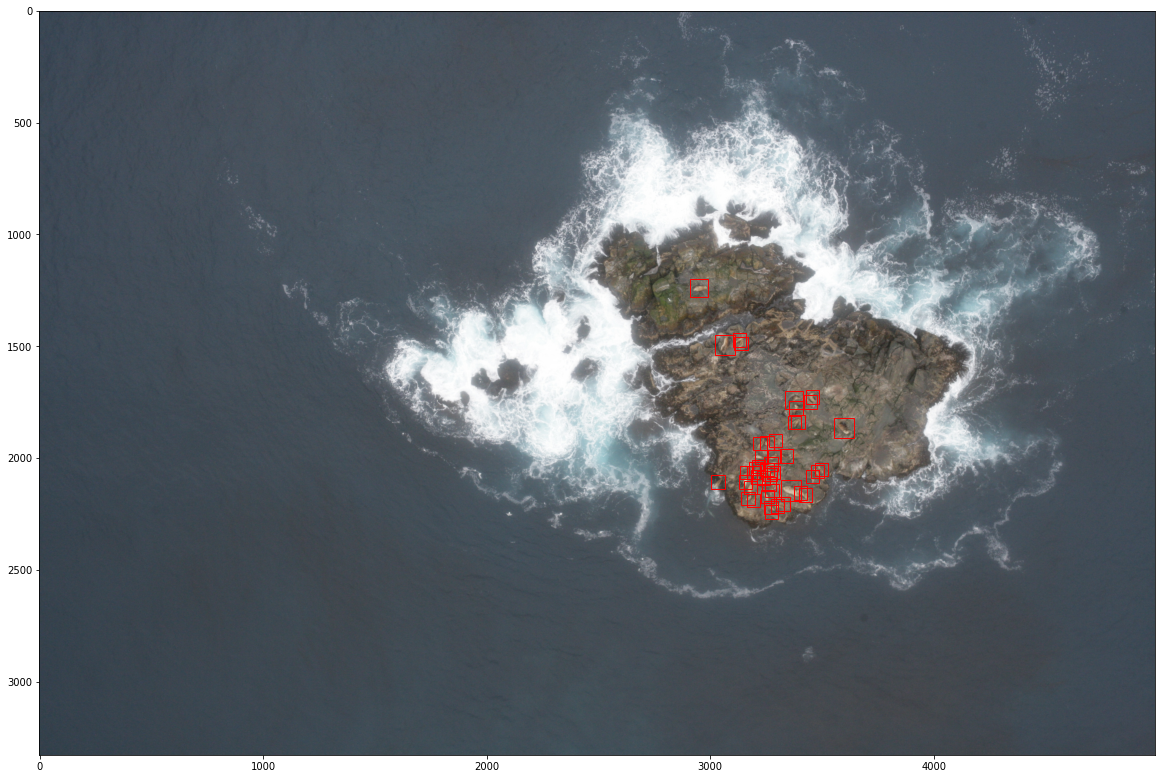

In [56]:
fig,ax = plt.subplots(1,figsize=(20,20))
img=plt.imread(files[3])
ax.imshow(img)
for i in range(len(img_bb_list[3])):
    height=img_bb_list[3][i][1]-img_bb_list[3][i][0]
    width=img_bb_list[3][i][3]-img_bb_list[3][i][2]
    rect = patches.Rectangle((img_bb_list[3][i][2],img_bb_list[3][i][0]),width,height,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

In [59]:
folder="downsampled_input/"
files = [os.path.join(folder, f) for f in os.listdir(folder) if (os.path.isfile(os.path.join(folder, f)) and  "csv" not in f and "json" not in f)]
files=sorted(files)
temp=[]
file_list=sorted(os.listdir(folder))
for i in range(len(blob_list)):
    img_shape=plt.imread(files[i]).shape
    for j in range(len(img_bb_list[i])):
        temp.append(np.array([file_list[i],blob_list[i][1][j],img_shape[1],img_shape[0],img_bb_list[i][j][2],img_bb_list[i][j][0], img_bb_list[i][j][3], img_bb_list[i][j][1]]))

file_data=pd.DataFrame(temp,columns=["filename","class","width","height","xmin","ymin","xmax","ymax"])
file_data.to_csv("tensorflow.csv")

NameError: name 'folder' is not defined

In [ ]:
path = 'tensorflow.csv'
save_json_path = 'traincoco.json'


data = pd.read_csv(path)

images = []
categories = []
annotations = []

category = {}
category["supercategory"] = 'None'
category["id"] = 0
category["name"] = 'None'
categories.append(category)

data['fileid'] = data['filename'].astype('category').cat.codes
data['categoryid']= pd.Categorical(data['class'],ordered= True).codes
data['categoryid'] = data['categoryid']+1
data['annid'] = data.index

def image(row):
    image = {}
    image["height"] = row.height
    image["width"] = row.width
    image["id"] = row.fileid
    image["file_name"] = row.filename
    return image

def category(row):
    category = {}
    category["supercategory"] = 'Seal'
    category["id"] = row.categoryid
    category["name"] = row[3]
    return category

def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid

    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]

    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

for row in data.itertuples():
    annotations.append(annotation(row))

imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
for row in imagedf.itertuples():
    images.append(image(row))

catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
for row in catdf.itertuples():
    categories.append(category(row))

data_coco = {}
data_coco["images"] = images
data_coco["categories"] = categories
data_coco["annotations"] = annotations
data_coco["info"] = {}
data_coco["licenses"] = {}


json.dump(data_coco, open(save_json_path, "w"), indent=4)